このノートブックは下記の参考文献を元にKaggleの「House Prices」コンペで

回帰予測（特徴量エンジニアリング、スタッキングやブレンディング等も含む）を学んだ。


# 【参考文献】

・[#1 House Prices Solution [top 1%]](https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1)

・[House Prices: Advanced Regression Techniques (Kaggle)](https://jackdry.com/house-prices-advanced-regression-techniques-kaggle)

・[TOP 50 |beginners | Stacking | LGB | XGB](https://www.kaggle.com/niteshx2/top-50-beginners-stacking-lgb-xgb)

In [18]:
import numpy as np
import pandas as pd
import pandas_profiling as pdp
from datetime import datetime
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")
print("The train data size is : {}".format(train_data.shape))
print("The test data size is : {}".format(test_data.shape))

The train data size is : (1460, 81)
The test data size is : (1459, 80)


In [20]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [21]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [22]:
all_data = pd.concat([train_data, test_data], join="outer", sort=False)

In [23]:
qualitative_data = all_data.select_dtypes(include=object)
quantitative_data = all_data.select_dtypes(exclude=object).drop(["Id", "SalePrice"], axis=1)

In [24]:
print("qualitative data :")
print("{}".format(qualitative_data.columns))
print("---------------------------------------------------------------------------------------------------------")
print("quantitative data:")
print("{}".format(quantitative_data.columns))

qualitative data :
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
---------------------------------------------------------------------------------------------------------
quantitative data:
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '

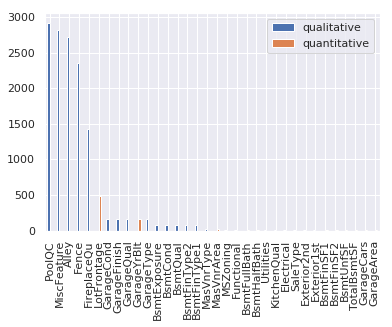

In [25]:
missing_qualitative = qualitative_data.isnull().sum()[qualitative_data.isnull().sum() > 0]
missing_quantitative = quantitative_data.isnull().sum()[quantitative_data.isnull().sum() > 0]
missing_all = pd.concat([missing_qualitative, missing_quantitative])
s0 = np.hstack((missing_qualitative.values, np.zeros(len(missing_quantitative))))
S0 = pd.Series(s0, index=missing_all.index, name="qualitative")
s1 = np.hstack((np.zeros(len(missing_qualitative)), missing_quantitative.values))
S1 = pd.Series(s1, index=missing_all.index, name="quantitative")
missing_concat = pd.concat([S0, S1], axis=1)
missing_concat["all"] = missing_concat["qualitative"] + missing_concat["quantitative"]
missing_graph = missing_concat.sort_values("all", ascending=False).drop("all", axis=1)
missing_graph.plot.bar()

In [26]:
print("{} attributes have missing values.".format(len(missing_all)))
print("(qualitative:{} , quantitative:{})".format(len(missing_qualitative), len(missing_quantitative)))

34 attributes have missing values.
(qualitative:23 , quantitative:11)


In [27]:
def johnson_su(y):
    gamma, delta, epsilon, lbda = stats.johnsonsu.fit(y)
    zj = gamma + delta*np.arcsinh((y-epsilon)/lbda)
    return zj

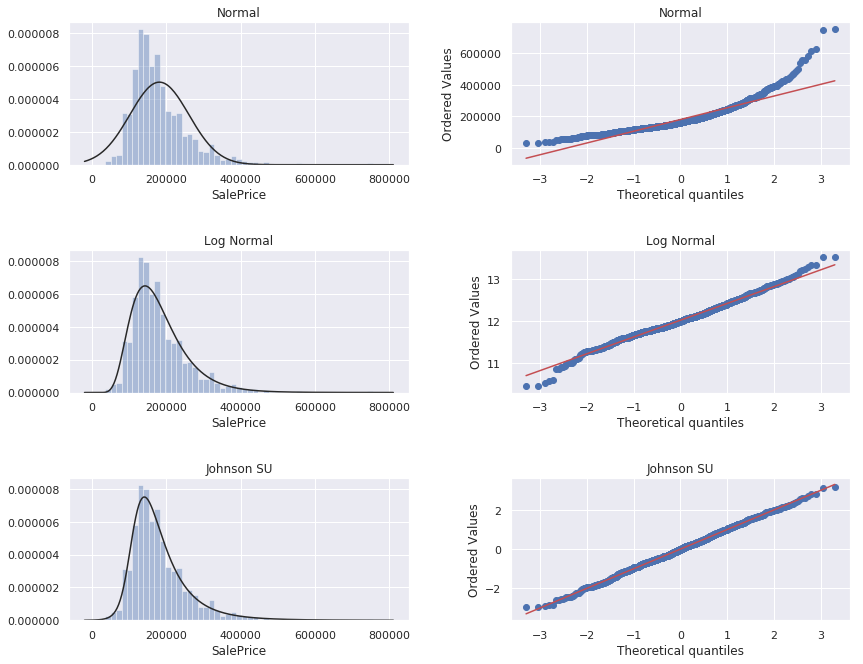

In [28]:
y = train_data["SalePrice"]
y1 = np.log1p(y)
y2 = johnson_su(y)
plt.figure(figsize=(14, 11))
sns.set()

norms = [stats.norm, stats.lognorm, stats.johnsonsu]
titles = ['Normal', 'Log Normal', 'Johnson SU']
Ys = [y, y1, y2]


for i, norm in enumerate(norms):
    plt.subplot(321 + i*2)
    plt.subplots_adjust(wspace=0.3, hspace=0.6) 
    sns.distplot(y, kde=False, fit=norm)
    plt.title(titles[i])

for i, Y in enumerate(Ys):
    plt.subplot(322 + i*2)
    res = stats.probplot(Y, plot=plt)
    plt.title(titles[i])

plt.show()

In [29]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.05
normal = quantitative_data
normal = normal.apply(test_normality)
print("Shapiro-Wilk normality test results")
print("'all p-value < 0.05' is '{}'".format(all(normal)))
print("Therefore, Spearman's correlation is better.")

Shapiro-Wilk normality test results
'all p-value < 0.05' is 'True'
Therefore, Spearman's correlation is better.


In [30]:
def encode(train_frame, test_frame=None):
    df_tr = train_frame.copy()
    if test_frame is None:
        pass
    else:
        df_te = test_frame.copy()
        
    for feature in qualitative_data.columns:
        a = pd.pivot_table(df_tr, index=feature, values="SalePrice").sort_values("SalePrice")
        a_dict = a.to_dict()
        for cat, o in a_dict["SalePrice"].items():
            df_tr.loc[df_tr[feature] == cat, feature+'_R'] = o
            if test_frame is None:
                pass
            else:
                df_te.loc[df_te[feature] == cat, feature+'_R'] = o
    
    if test_frame is None:
        return df_tr
    else:
        return df_tr, df_te

In [31]:
qual_encoded = []
for i in qualitative_data.columns:
    qual_encoded.append(i+'_R')

print(qual_encoded)
all_qual = np.append(qualitative_data.columns.values, qual_encoded)

['MSZoning_R', 'Street_R', 'Alley_R', 'LotShape_R', 'LandContour_R', 'Utilities_R', 'LotConfig_R', 'LandSlope_R', 'Neighborhood_R', 'Condition1_R', 'Condition2_R', 'BldgType_R', 'HouseStyle_R', 'RoofStyle_R', 'RoofMatl_R', 'Exterior1st_R', 'Exterior2nd_R', 'MasVnrType_R', 'ExterQual_R', 'ExterCond_R', 'Foundation_R', 'BsmtQual_R', 'BsmtCond_R', 'BsmtExposure_R', 'BsmtFinType1_R', 'BsmtFinType2_R', 'Heating_R', 'HeatingQC_R', 'CentralAir_R', 'Electrical_R', 'KitchenQual_R', 'Functional_R', 'FireplaceQu_R', 'GarageType_R', 'GarageFinish_R', 'GarageQual_R', 'GarageCond_R', 'PavedDrive_R', 'PoolQC_R', 'Fence_R', 'MiscFeature_R', 'SaleType_R', 'SaleCondition_R']


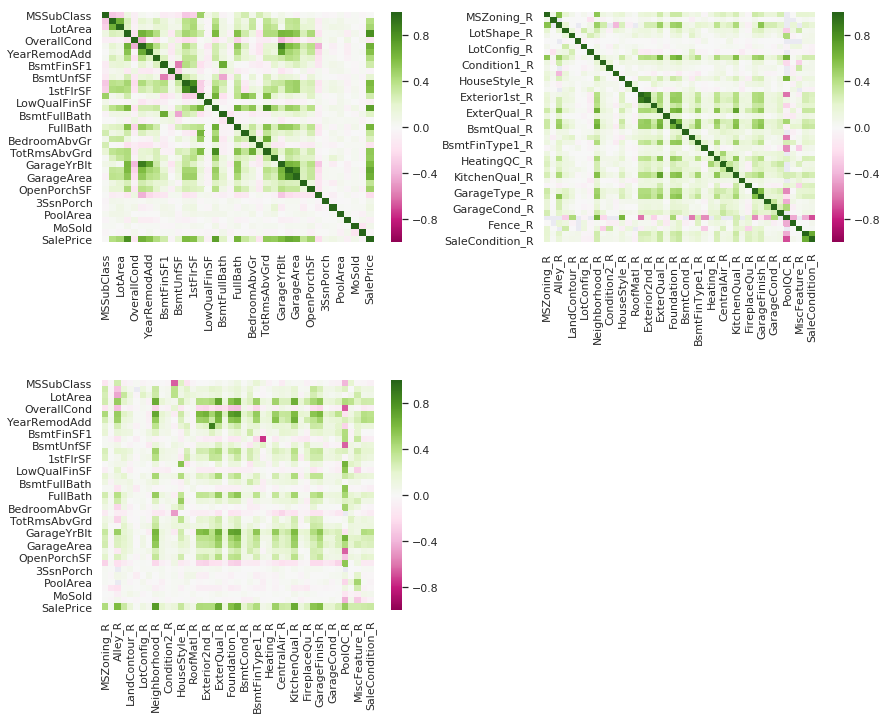

In [32]:
spearman_corr  = encode(train_data).rank(method='dense')
quan_corr = spearman_corr.drop(np.append(all_qual, "Id"), axis=1)
qual_corr = spearman_corr[qual_encoded]
qual_quan_corr = spearman_corr.drop(np.append(qualitative_data.columns.values, "Id"), axis=1)
all_corr = [quan_corr, qual_corr, qual_quan_corr]

plt.figure(figsize=(14, 11))

for i in range(len (all_corr)):
    plt.subplots_adjust(wspace=0.3, hspace=0.6) 
    plt.subplot(221 + i)
    if i < 2:
        corr = all_corr[i].corr(method='spearman')
    else:
        corr = all_corr[i].corr(method='spearman').loc[quan_corr.columns, qual_corr.columns]
    
    sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap='PiYG')

plt.show()

In [33]:
"""
columns = qual_quan_corr.columns

for column in columns:
    s = qual_quan_corr.corr(method='spearman')[column].values
    q = qual_quan_corr.corr(method='spearman').index[abs(s) > 0.7]
    
    if len(q) > 1:
        plt.figure(figsize=(18, 11))
        plt.title(column)
        for i in range(len(q)):
            plt.subplots_adjust(wspace=0.4, hspace=0.3) 
            if q[i] != column:
                plt.subplot(341 + i)
                plt.scatter(qual_quan_corr[column], qual_quan_corr[q[i]], alpha=0.1)
                plt.xlabel(column, fontsize=18)
                plt.ylabel(q[i], fontsize=18)
    
plt.show()
"""

"\ncolumns = qual_quan_corr.columns\n\nfor column in columns:\n    s = qual_quan_corr.corr(method='spearman')[column].values\n    q = qual_quan_corr.corr(method='spearman').index[abs(s) > 0.7]\n    \n    if len(q) > 1:\n        plt.figure(figsize=(18, 11))\n        plt.title(column)\n        for i in range(len(q)):\n            plt.subplots_adjust(wspace=0.4, hspace=0.3) \n            if q[i] != column:\n                plt.subplot(341 + i)\n                plt.scatter(qual_quan_corr[column], qual_quan_corr[q[i]], alpha=0.1)\n                plt.xlabel(column, fontsize=18)\n                plt.ylabel(q[i], fontsize=18)\n    \nplt.show()\n"

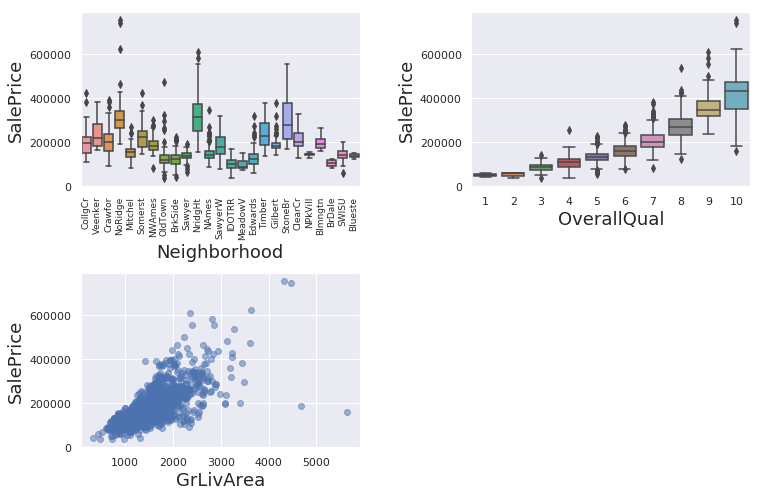

SalePrice vs Neighborhood_R:0.7557789170655119
SalePrice vs OverallQual:0.8098285862017292
SalePrice vs GrLivArea:0.7313095834659141


In [34]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.5) 

plt.subplot(221)
sns.boxplot(x="Neighborhood", y="SalePrice", data=train_data)
plt.xticks(fontsize=9, rotation=90)
plt.xlabel("Neighborhood", fontsize=18)
plt.ylabel("SalePrice", fontsize=18)
plt.subplot(222)
sns.boxplot(x="OverallQual", y="SalePrice", data=train_data)
plt.xlabel("OverallQual", fontsize=18)
plt.ylabel("SalePrice", fontsize=18)
plt.subplot(223)
plt.scatter(train_data["GrLivArea"], train_data["SalePrice"], alpha=0.5)
plt.xlabel("GrLivArea", fontsize=18)
plt.ylabel("SalePrice", fontsize=18)

plt.show()

print("SalePrice vs Neighborhood_R:{}".format(qual_quan_corr.corr(method='spearman')
                                              .loc["Neighborhood_R", "SalePrice"]))
print("SalePrice vs OverallQual:{}".format(qual_quan_corr.corr(method='spearman')
                                              .loc["OverallQual", "SalePrice"]))
print("SalePrice vs GrLivArea:{}".format(qual_quan_corr.corr(method='spearman')
                                           .loc["GrLivArea", "SalePrice"]))

Data procesing

In [35]:
train, test = encode(train_data.copy(), test_data.copy())
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
y = train['SalePrice'].reset_index(drop=True)

train_features = train
test_features = test
features = pd.concat([train_features, test_features], join="outer", sort=False).reset_index(drop=True)
features[qual_encoded] = features[qual_encoded].rank(method='dense')
#features[qual_encoded] = features[qual_encoded].rank(method='average')

features.shape

(2917, 123)

In [36]:
def encode_C(features_frame):
    df_tr = features_frame.copy()
        
    for feature in qualitative_data.columns:
        a = pd.pivot_table(df_tr, index=feature, values='SalePrice', aggfunc='count')
        a_dict = a.to_dict()
        for cat, o in a_dict["SalePrice"].items():
            df_tr.loc[df_tr[feature] == cat, feature+'_C'] = o
    
    return df_tr

In [37]:
qual_encoded_C = []
for i in qualitative_data.columns:
    qual_encoded_C.append(i+'_C')

print(qual_encoded_C)

['MSZoning_C', 'Street_C', 'Alley_C', 'LotShape_C', 'LandContour_C', 'Utilities_C', 'LotConfig_C', 'LandSlope_C', 'Neighborhood_C', 'Condition1_C', 'Condition2_C', 'BldgType_C', 'HouseStyle_C', 'RoofStyle_C', 'RoofMatl_C', 'Exterior1st_C', 'Exterior2nd_C', 'MasVnrType_C', 'ExterQual_C', 'ExterCond_C', 'Foundation_C', 'BsmtQual_C', 'BsmtCond_C', 'BsmtExposure_C', 'BsmtFinType1_C', 'BsmtFinType2_C', 'Heating_C', 'HeatingQC_C', 'CentralAir_C', 'Electrical_C', 'KitchenQual_C', 'Functional_C', 'FireplaceQu_C', 'GarageType_C', 'GarageFinish_C', 'GarageQual_C', 'GarageCond_C', 'PavedDrive_C', 'PoolQC_C', 'Fence_C', 'MiscFeature_C', 'SaleType_C', 'SaleCondition_C']


In [38]:
features = encode_C(features)
features.shape

(2917, 166)

In [39]:
missing_all_features = features.isnull().sum()[features.isnull().sum() > 0]
missing_all_features

MSZoning             4
LotFrontage        486
Alley             2719
Utilities            2
Exterior1st          1
Exterior2nd          1
MasVnrType          24
MasVnrArea          23
BsmtQual            81
BsmtCond            82
BsmtExposure        82
BsmtFinType1        79
BsmtFinSF1           1
BsmtFinType2        80
BsmtFinSF2           1
BsmtUnfSF            1
TotalBsmtSF          1
Electrical           1
BsmtFullBath         2
BsmtHalfBath         2
KitchenQual          1
Functional           2
FireplaceQu       1420
GarageType         157
GarageYrBlt        159
GarageFinish       159
GarageCars           1
GarageArea           1
GarageQual         159
GarageCond         159
                  ... 
GarageFinish_R     159
GarageQual_R       159
GarageCond_R       159
PoolQC_R          2908
Fence_R           2346
MiscFeature_R     2812
SaleType_R           1
MSZoning_C           4
Alley_C           2719
Utilities_C          2
Exterior1st_C        1
Exterior2nd_C        1
MasVnrType_

Fill in missing values.

In [40]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [41]:
list_None = ["Alley", "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure",
            "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", 
            "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
for col in list_None:
    features[col] = features[col].fillna("None")

In [42]:
list_0 = ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
         "BsmtFullBath", "BsmtHalfBath", "GarageYrBlt", "GarageCars", "GarageArea"]
for col in list_0:
    features[col] = features[col].fillna(0)

In [43]:
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

In [44]:
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0]) 
features['Utilities'] = features['Utilities'].fillna(features['Utilities'].mode()[0]) 
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0]) 
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [45]:
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [46]:
features.update(features[qual_encoded].fillna(0))
features.update(features[qual_encoded_C].fillna(0))

In [47]:
object_data = features.select_dtypes(exclude=object).drop(
    ["LotFrontage", "SalePrice"], axis=1)
object_data.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'PoolQC_C', 'Fence_C', 'MiscFeature_C', 'SaleType_C', 'SaleCondition_C',
       'YrBltAndRemod', 'TotalSF', 'Total_sqr_footage', 'Total_Bathrooms',
       'Total_porch_sf'],
      dtype='object', length=123)

In [48]:
johnsonsu_list = ["LotArea", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "TotalSF",
                 "Total_sqr_footage"]   # & "SalePrice"
log_list = ["1stFlrSF", "GrLivArea", "Total_sqr_footage"]
skew_feature = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath','BsmtHalfBath', 'FullBath', 'HalfBath', 
       'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
       'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
       '3SsnPorch','ScreenPorch', 'PoolArea', 'MiscVal', 'YrBltAndRemod',
       'Total_Bathrooms', 'Total_porch_sf']

In [49]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        skew_feature.append(i)
skew_features = features[skew_feature].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = list(set(high_skew.index))


for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
"""
for i in log_list:
    features[i] = np.log1p(features[i])
"""
"""
for i in johnsonsu_list:
    features[i] = johnson_su(features[i])
"""

'\nfor i in johnsonsu_list:\n    features[i] = johnson_su(features[i])\n'

In [50]:
features.isnull().sum()[features.isnull().sum() > 0]

LotFrontage     486
SalePrice      1459
dtype: int64

Fill in remaining missing values with multiple imputation using R.

In [51]:
R_features = train_data.drop(['Id'], axis=1)
R_column = R_features.columns
R_data = features[R_column]
#features.to_csv("data3.csv")

In [52]:
new_features1 = pd.read_csv("./micedata/log_rf__micedata1.csv")
features["LotFrontage"] = new_features1["LotFrontage"]
features.drop(['SalePrice'], axis=1, inplace=True)
features.shape

(2917, 170)

In [53]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [54]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 422)

In [55]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 422), (1458,), (1459, 422))

In [56]:
residuals = y - LinearRegression().fit(X, y).predict(X)
outliers = residuals[np.abs(zscore(residuals)) > 3].index

In [57]:
outliers

Int64Index([  30,   66,   88,  107,  431,  462,  495,  559,  580,  587,  631,
             687,  727,  773,  873,  967,  969, 1061, 1211, 1322, 1430, 1451],
           dtype='int64')

In [58]:
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

overfit

['MSSubClass_150']

In [59]:
X.shape, y.shape, X_sub.shape

((1436, 421), (1436,), (1459, 421))

In [60]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param_grid = [
    {'alpha': [17.8, 17.9, 18.0, 18.1, 18.2, 18.3, 18.4, 18.5, 18.6, 18.7]},
  ]

ridge_reg = Ridge(random_state=42)
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=42,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [17.8, 17.9, 18.0, 18.1, 18.2, 18.3, 18.4,
                                    18.5, 18.6, 18.7]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [77]:
grid_search.best_params_

{'alpha': 18.2}

In [78]:
grid_search.best_estimator_

Ridge(alpha=18.2, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)

In [79]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.09323725619467316 {'alpha': 17.8}
0.09323714521480836 {'alpha': 17.9}
0.09323707096661667 {'alpha': 18.0}
0.09323703292229533 {'alpha': 18.1}
0.09323703056375036 {'alpha': 18.2}
0.0932370633823698 {'alpha': 18.3}
0.0932371308787993 {'alpha': 18.4}
0.09323723256272691 {'alpha': 18.5}
0.0932373679526732 {'alpha': 18.6}
0.09323753657578654 {'alpha': 18.7}


In [80]:
from sklearn.linear_model import Lasso


param_grid = [
    {'alpha': [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]},
  ]

lasso_reg = Lasso(random_state=42)
grid_search = GridSearchCV(lasso_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X, y)

/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9952764625992194, tolerance: 0.01777121768230658
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.957581299936278, tolerance: 0.01701352342959242
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0101694915699913, tolerance: 0.017214685811651486
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7406800244974896, tolerance: 0.01777121768230658
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.677908538841396, tolerance: 0.01701352342959242
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.760630909446972, tolerance: 0.017214685811651486
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [5e-05, 0.0001, 0.0002, 0.0003, 0.0004,
                                    0.0005, 0.0006, 0.0007, 0.0008]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [81]:
grid_search.best_params_

{'alpha': 0.0003}

In [82]:
grid_search.best_estimator_

Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [83]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.09583856317413356 {'alpha': 5e-05}
0.09379548863325061 {'alpha': 0.0001}
0.09220323817805678 {'alpha': 0.0002}
0.09168886442559386 {'alpha': 0.0003}
0.09193665756882284 {'alpha': 0.0004}
0.0923869566539638 {'alpha': 0.0005}
0.09288767520338188 {'alpha': 0.0006}
0.09349721882271136 {'alpha': 0.0007}
0.09403613313896915 {'alpha': 0.0008}


In [84]:
from sklearn.linear_model import ElasticNet
#elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

param_grid = [
    {'alpha': [0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.0010,]},
    {'l1_ratio':[0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8]}
  ]

elastic_net_reg = ElasticNet(random_state=42)
grid_search = GridSearchCV(elastic_net_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X, y)

/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.094212574988505, tolerance: 0.01777121768230658
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.273790171013929, tolerance: 0.01701352342959242
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4477626777690635, tolerance: 0.017214685811651486
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6355581875343463, tolerance: 0.01777121768230658
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5838825008535076, tolerance: 0.01701352342959242
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.645094448117105, tolerance: 0.017214685811651486
  positive)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=42, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
                                    0.0009, 0.001]},
                         {'l1_ratio': [0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7,
                                       0.8]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [85]:
grid_search.best_params_

{'alpha': 0.0006}

In [86]:
grid_search.best_estimator_

ElasticNet(alpha=0.0006, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

In [87]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.09216792760772412 {'alpha': 0.0004}
0.09186918178706062 {'alpha': 0.0005}
0.09174891528198983 {'alpha': 0.0006}
0.09183992827316018 {'alpha': 0.0007}
0.09201656664617372 {'alpha': 0.0008}
0.09222600910097017 {'alpha': 0.0009}
0.09246238912524186 {'alpha': 0.001}
0.14042338031466042 {'l1_ratio': 0.25}
0.14100188008959694 {'l1_ratio': 0.3}
0.14178139019183195 {'l1_ratio': 0.35}
0.14259351617529512 {'l1_ratio': 0.4}
0.14346172548916716 {'l1_ratio': 0.5}
0.14420796580866846 {'l1_ratio': 0.6}
0.1450468500016361 {'l1_ratio': 0.7}
0.1459104107429527 {'l1_ratio': 0.8}


In [88]:
from sklearn.svm import SVR

param_grid = [
    {'C': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]},
    {'epsilon':[0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011]},
    {'gamma':[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]}
  ]

svr_reg = SVR()
grid_search = GridSearchCV(svr_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X, y)

/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/skle

/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/skle

/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/skle

/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kazu_h/anaconda3/lib/python3.6/site-packages/skle

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]},
                         {'epsilon': [0.005, 0.006, 0.007, 0.008, 0.009, 0.01,
                                      0.011]},
                         {'gamma': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                    0.0006]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [89]:
grid_search.best_params_

{'gamma': 0.0001}

In [90]:
grid_search.best_estimator_

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [91]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.3902022678178262 {'C': 5}
0.3902022678178262 {'C': 10}
0.3902022678178262 {'C': 15}
0.3902022678178262 {'C': 20}
0.3902022678178262 {'C': 25}
0.3902022678178262 {'C': 30}
0.3902022678178262 {'C': 35}
0.3902022678178262 {'C': 40}
0.3902022678178262 {'C': 45}
0.3902022678178262 {'C': 50}
0.39002088380468447 {'epsilon': 0.005}
0.3900211364925541 {'epsilon': 0.006}
0.3900212521158912 {'epsilon': 0.007}
0.3900214269072026 {'epsilon': 0.008}
0.3900218955657856 {'epsilon': 0.009}
0.390022328016465 {'epsilon': 0.01}
0.39002257710647675 {'epsilon': 0.011}
0.38891610144235456 {'gamma': 0.0001}
0.38942405096009014 {'gamma': 0.0002}
0.38963422631903344 {'gamma': 0.0003}
0.3897460613668647 {'gamma': 0.0004}
0.3898157148638708 {'gamma': 0.0005}
0.3898655370503825 {'gamma': 0.0006}


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                 max_features='sqrt', min_samples_leaf=15,
                                 min_samples_split=10, loss='huber', random_state =42,)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=538,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [93]:
bst_n_estimators

538

In [94]:
min_error = np.min(errors)

Text(0.5, 1.0, 'Validation error')

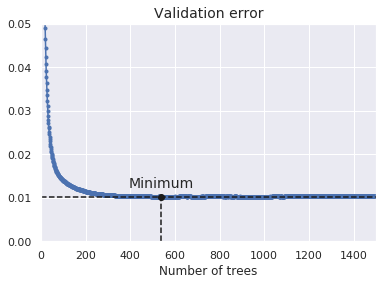

In [95]:
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 1500], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 1500, 0, 0.05])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

In [96]:
alphas_alt = [17.8, 17.9, 18.0, 18.1, 18.2, 18.3, 18.4, 18.5, 18.6, 18.7]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.0010, 0.0011]
e_l1ratio = [0.3]

In [97]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, 
                                              random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                                        cv=kfolds, l1_ratio=e_l1ratio))
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0001,))
gbr = GradientBoostingRegressor(n_estimators=bst_n_estimators, learning_rate=0.05,
                                max_depth=4, max_features='sqrt', min_samples_leaf=15,
                                min_samples_split=10, loss='huber', random_state =42) 

In [98]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [99]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [100]:
score = cv_rmse(ridge)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

RIDGE: 0.0911 (0.0068)
 2020-01-19 17:01:49.892655
LASSO: 0.0899 (0.0075)
 2020-01-19 17:02:56.535275
elastic net: 0.0900 (0.0073)
 2020-01-19 17:03:44.579805
SVR: 0.2787 (0.0271)
 2020-01-19 17:03:54.309482
gbr: 0.0970 (0.0080)
 2020-01-19 17:04:04.951646
lightgbm: 0.0954 (0.0098)
 2020-01-19 17:04:14.272563
[17:04:14] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:18] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:23] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:28] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:33] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:

In [101]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [102]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[17:07:26] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:31] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:35] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:40] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:44] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:53] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:13] WARNING: /home/kazu_h/xgboost/src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridg

In [103]:

def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.05 * svr_model_full_data.predict(X)) + \
            (0.05 * gbr_model_full_data.predict(X)) + \
            (0.05 * xgb_model_full_data.predict(X)) + \
            (0.05 * lgb_model_full_data.predict(X)) + \
            (0.5 * stack_gen_model.predict(np.array(X))))


In [104]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.04615185149441287


In [105]:
print('Predict submission')
submission = pd.read_csv("./sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))
submission.head()

Predict submission


,Id,SalePrice
0,1461,124318.0
1,1462,162468.0
2,1463,190578.0
3,1464,201897.0
4,1465,188835.0


In [106]:
#submission.to_csv("./submissiondata/submission20200119.csv", index=False)

In [107]:
y1 = np.floor(np.expm1(y))
y1.rename(columns={'SalePrice': 'target'}, inplace=True)

0       208499.0
1       181500.0
2       223500.0
3       139999.0
4       249999.0
5       143000.0
6       306999.0
7       199999.0
8       129900.0
9       118000.0
10      129500.0
11      344999.0
12      144000.0
13      279499.0
14      156999.0
15      131999.0
16      149000.0
17       90000.0
18      158999.0
19      139000.0
20      325299.0
21      139400.0
22      230000.0
23      129900.0
24      153999.0
25      256299.0
26      134800.0
27      305999.0
28      207500.0
29       68499.0
          ...   
1426    118999.0
1427    182900.0
1428    192139.0
1429    143750.0
1431    186500.0
1432    159999.0
1433    174000.0
1434    120499.0
1435    394616.0
1436    149699.0
1437    197000.0
1438    191000.0
1439    149300.0
1440    310000.0
1441    121000.0
1442    179599.0
1443    129000.0
1444    157899.0
1445    240000.0
1446    112000.0
1447     92000.0
1448    135999.0
1449    287089.0
1450    145000.0
1452    185000.0
1453    175000.0
1454    210000.0
1455    266499

In [108]:
y.iloc[:] = np.floor(np.expm1(blend_models_predict(X)))

In [109]:
y.rename(columns={'SalePrice': 'predict'}, inplace=True)

0       207961.0
1       191021.0
2       218407.0
3       153378.0
4       277918.0
5       148516.0
6       291388.0
7       211004.0
8       128744.0
9       119556.0
10      132383.0
11      365764.0
12      138051.0
13      234214.0
14      155512.0
15      133592.0
16      151191.0
17       98129.0
18      155180.0
19      128889.0
20      327142.0
21      133446.0
22      229827.0
23      134574.0
24      153559.0
25      251862.0
26      133493.0
27      302533.0
28      199708.0
29       65178.0
          ...   
1426    111638.0
1427    185792.0
1428    190109.0
1429    134983.0
1431    192907.0
1432    163133.0
1433    173468.0
1434    120279.0
1435    372570.0
1436    149964.0
1437    189411.0
1438    199965.0
1439    144883.0
1440    334157.0
1441    113231.0
1442    180439.0
1443    130096.0
1444    154906.0
1445    253199.0
1446    110008.0
1447     89483.0
1448    134155.0
1449    272800.0
1450    136167.0
1452    190633.0
1453    176678.0
1454    207425.0
1455    266439

In [110]:
df = pd.concat([y, y1], axis=1)
df.sort_values([0], inplace=True)
df.reset_index(inplace=True)
df["index"] = df.index + 1

In [111]:
df["RMSE"] = np.sqrt(np.square(df[0] - df[1]))

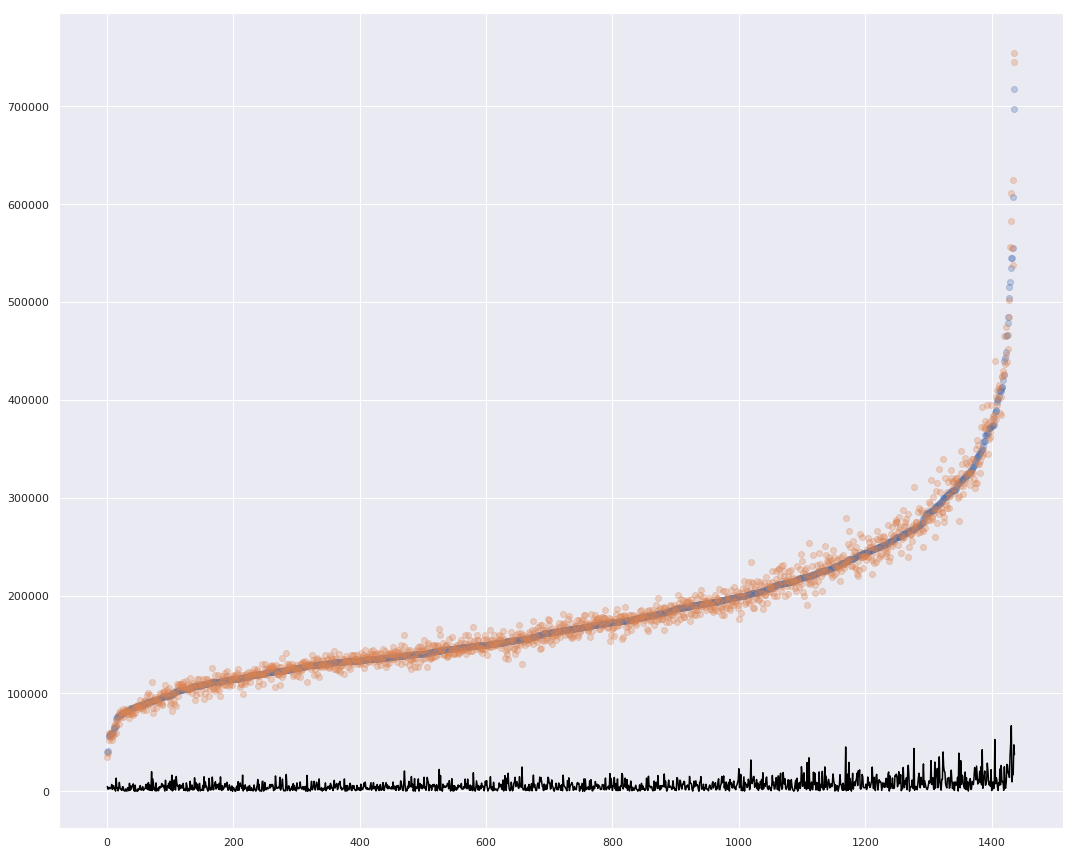

In [112]:
plt.figure(figsize=(18, 15))
plt.scatter(df["index"], df[0], alpha=0.3)
plt.scatter(df["index"], df[1], alpha=0.3)
plt.plot(df["index"], df["RMSE"], color="black")
#plt.xlim([1600, 1800])
#plt.ylim([100000, 200000])

In [ ]:
"""
def inverse_johnson_su(y):
    gamma, delta, epsilon, lbda = stats.johnsonsu.fit(train_data["SalePrice"])
    zj = epsilon + lbda*np.sinh((y-gamma)/delta)
    return zj
"""

In [ ]:
"""
print('Predict submission')
submission = pd.read_csv("./sample_submission.csv")
submission.iloc[:,1] = inverse_johnson_su(blend_models_predict(X_sub))
"""

In [ ]:
#submission.to_csv("./submissiondata/blend.csv", index=False)